# Lake Whillans Classification Problem

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn import metrics


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV , LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.filterwarnings('ignore')
np.random.seed(0)

Run Consolidated google sheet to interesting case tagger. Use the debug file as the input source.

In [2]:
df=pd.read_csv('./debug.csv')

In [3]:
df.is_interesting.sum()

1917.0

In [4]:
df.is_contact.sum()

384

The Probability of interesting cases tagged by tagger is 20%

In [5]:
df.is_contact.sum()/float(df.is_interesting.sum())

0.20031298904538342

The Probability of interesting cases tagged by tagger is 2% of the data. This is a case of highly imbalanced data. 

In [6]:
df.is_contact.sum()/float(len(df))

0.020489835120858012

In [7]:
df.columns

Index(['10_k', '10_k_signed', 'Civil Action Number', 'Field of Law',
       'Judicial Officers', 'Product Liability Findings', 'antitrust',
       'antitrust_findings', 'attorney', 'attorney_defendant',
       ...
       'exclude_damages', 'exclude_case_status', 'exclude_parties',
       'exclude_misc_findings', 'exclude_flags', 'is_interesting',
       'interesting_rule', 'needs_review', 'needs_review_rule',
       'needs_review_priority'],
      dtype='object', length=161)

In [8]:
df.columns.tolist()

['10_k',
 '10_k_signed',
 'Civil Action Number',
 'Field of Law',
 'Judicial Officers',
 'Product Liability Findings',
 'antitrust',
 'antitrust_findings',
 'attorney',
 'attorney_defendant',
 'attorney_emails',
 'attorney_plaintiff',
 'attorney_third_party',
 'batch_name',
 'books_and_records',
 'case_id',
 'case_id_from_file_id',
 'case_resolution',
 'case_status',
 'case_type',
 'cause_of_action',
 'civil_action_id',
 'class_action_text',
 'cleaned_title',
 'commercial_findings',
 'court',
 'court_abbr',
 'court_abbr_from_file_name',
 'court_id',
 'court_name',
 'court_name_from_file_name',
 'created_time',
 'ctid',
 'damages',
 'damages_unclear',
 'date_filed',
 'defendant',
 'defendant_am_niep',
 'defendant_am_revenue',
 'defendant_attorney',
 'defendant_fortune_ranking',
 'defendant_is_stock_exchange_registered',
 'defendant_law_firm',
 'defendant_market_cap_value',
 'defendant_usnews_national',
 'defendant_usnews_regional',
 'determined_at_trial',
 'district_judge',
 'district_j

In [9]:
df=df[['fokal_key',
 'usnews_score_natl',
 'usnews_score_regl',
 'amlaw_score_niep',
 'amlaw_score_rev_rank',
 'lawfirm_score',
 'company_score',
 'generic_high_damages_score',
 'non_punitive_damages_score',
 'max_money_score',
 'is_low_damage',
 'very_high_max_money',
 'money_too_high',
 'num_low_money1',
 'num_money_mill',
 'exclude_public_securities',
 'exclude_casename',
 'exclude_case_resolution',
 'exclude_shareholder_derivative',
 'exclude_security_classaction',
 'exclude_pure_patent',
 'exclude_pure_trademark',
 'exclude_pure_copyright',
 'exclude_class_action',
 'exclude_damages',
 'exclude_case_status',
 'exclude_parties',
 'exclude_misc_findings',
 'exclude_flags',
 'is_interesting',
 'is_contact',
 'interesting_rule',
 'needs_review',
 'needs_review_rule',
 'needs_review_priority']]

In [10]:
df.head(10)

,fokal_key,usnews_score_natl,usnews_score_regl,amlaw_score_niep,amlaw_score_rev_rank,lawfirm_score,company_score,generic_high_damages_score,non_punitive_damages_score,max_money_score,...,exclude_case_status,exclude_parties,exclude_misc_findings,exclude_flags,is_interesting,is_contact,interesting_rule,needs_review,needs_review_rule,needs_review_priority
0,4:19-cv-00308_E.D.Ark.,5.0,10.0,5.0,5.0,25.0,40.0,0.0,0.0,5.0,...,0,0.0,0.0,NaN,0.0,False,NaN,1.0,high_max_money,low
1,8:18-cv-01762_C.D.Cal.,10.0,10.0,5.0,5.0,30.0,20.0,0.0,0.0,0.0,...,0,0.0,0.0,"class_action,low_damages",0.0,False,NaN,1.0,high_profile_company,low
2,1:19-cv-00274_W.D.Mich.,20.0,20.0,10.0,10.0,60.0,30.0,0.0,0.0,0.0,...,0,0.0,0.0,low_damages,0.0,False,NaN,1.0,high_profile_company,low
3,6:18-cv-01305_D.Kan.,0.0,5.0,0.0,0.0,5.0,20.0,0.0,0.0,0.0,...,0,0.0,0.0,low_damages,0.0,False,NaN,1.0,high_profile_company,low
4,2:16-cv-03739_E.D.N.Y.,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,...,0,0.0,0.0,low_damages,0.0,False,NaN,1.0,high_profile_company,low
5,1:18-cv-02442_S.D.N.Y.,10.0,10.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,...,0,0.0,0.0,pure_trademark,0.0,False,NaN,1.0,high_profile_company,low
6,0:18-cv-02046_D.Minn.,0.0,5.0,0.0,0.0,5.0,20.0,0.0,0.0,0.0,...,0,0.0,0.0,low_damages,0.0,False,NaN,1.0,high_profile_company,low
7,2:17-at-01053_E.D.Cal.,5.0,5.0,0.0,0.0,10.0,20.0,0.0,0.0,0.0,...,0,0.0,0.0,low_damages,0.0,False,NaN,1.0,high_profile_company,low
8,1:17-cv-05405_E.D.N.Y.,0.0,5.0,0.0,0.0,5.0,20.0,0.0,0.0,0.0,...,0,0.0,0.0,"pure_trademark,low_damages,pure_patent",0.0,False,NaN,1.0,high_profile_company,low
9,2:18-cv-10250_E.D.Mich.,20.0,10.0,10.0,10.0,50.0,20.0,0.0,0.0,0.0,...,0,0.0,0.0,low_damages,0.0,False,high_profile_case,1.0,interesting_but_exclusion,low


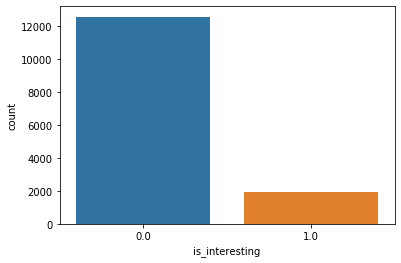

In [11]:
sns.countplot(x='is_interesting',data=df)

### Sample Data 

#### Since the data set is highly imbalanced. As suggested by madhav to keep 1500:300 contact vs non contact cases

In [12]:
ic_df=df[df['is_contact']==True]
nic_df=df[df['is_contact']==False]

ic_df.shape

(384, 35)

In [13]:
nic_df=nic_df.iloc[0:1500,:]

nic_df.shape

(1500, 35)

In [14]:
data_set=pd.concat([nic_df,ic_df],ignore_index=True)

print(data_set.shape)
data_set.tail()

(1884, 35)


,fokal_key,usnews_score_natl,usnews_score_regl,amlaw_score_niep,amlaw_score_rev_rank,lawfirm_score,company_score,generic_high_damages_score,non_punitive_damages_score,max_money_score,...,exclude_case_status,exclude_parties,exclude_misc_findings,exclude_flags,is_interesting,is_contact,interesting_rule,needs_review,needs_review_rule,needs_review_priority
1879,3:18-cv-07743_N.D.Cal.,0.0,0.0,0.0,0.0,0.0,30.0,0.0,20.0,0.0,...,0,0.0,0.0,NaN,1.0,True,high_non_punitive_damages,0.0,NaN,NaN
1880,1:18-cv-00160_D.Colo.,40.0,30.0,20.0,10.0,100.0,20.0,0.0,0.0,0.0,...,0,0.0,0.0,NaN,1.0,True,high_profile_case,0.0,NaN,NaN
1881,1:18-cv-04349_S.D.N.Y.,20.0,15.0,10.0,10.0,55.0,20.0,20.0,20.0,5.0,...,0,0.0,0.0,NaN,1.0,True,high_non_punitive_damages,0.0,NaN,NaN
1882,6:17-cv-01075_D.Kan.,45.0,30.0,20.0,20.0,115.0,20.0,20.0,0.0,5.0,...,0,0.0,0.0,NaN,1.0,True,generic_high_damages,0.0,NaN,NaN
1883,3:17-cv-02191_N.D.Cal.,20.0,15.0,10.0,10.0,55.0,20.0,0.0,0.0,0.0,...,0,0.0,0.0,NaN,1.0,True,high_profile_case,0.0,NaN,NaN


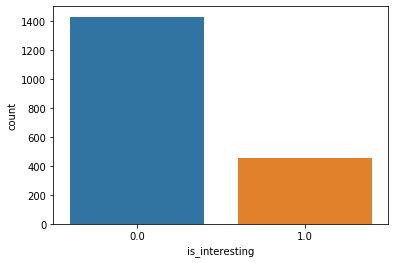

In [15]:
sns.countplot(x='is_interesting',data=data_set)

In [16]:
data_set.is_interesting.sum()

454.0

In [17]:
data_set.is_contact.sum()

384

The Sample Data where the intersting cases are 300 and 1500 non interesting cases. This will be a biased data set and we build a mode here and check it performance over entire data set.
Probability of interesting cases tagged by tagger is 84.5%

In [18]:
data_set.is_contact.sum()/float(data_set.is_interesting.sum())

0.8458149779735683

The Probability of interesting cases tagged by tagger is 20% of the data. This is a case of highly imbalanced data. 

In [19]:
data_set.is_contact.sum()/float(len(data_set))

0.20382165605095542

In [20]:
data_set.set_index('fokal_key',drop=True,inplace=True)

data_set.tail()

,usnews_score_natl,usnews_score_regl,amlaw_score_niep,amlaw_score_rev_rank,lawfirm_score,company_score,generic_high_damages_score,non_punitive_damages_score,max_money_score,is_low_damage,...,exclude_case_status,exclude_parties,exclude_misc_findings,exclude_flags,is_interesting,is_contact,interesting_rule,needs_review,needs_review_rule,needs_review_priority
fokal_key,,,,,,,,,,,,,,,,,,,,,
3:18-cv-07743_N.D.Cal.,0.0,0.0,0.0,0.0,0.0,30.0,0.0,20.0,0.0,0.0,...,0,0.0,0.0,NaN,1.0,True,high_non_punitive_damages,0.0,NaN,NaN
1:18-cv-00160_D.Colo.,40.0,30.0,20.0,10.0,100.0,20.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,NaN,1.0,True,high_profile_case,0.0,NaN,NaN
1:18-cv-04349_S.D.N.Y.,20.0,15.0,10.0,10.0,55.0,20.0,20.0,20.0,5.0,0.0,...,0,0.0,0.0,NaN,1.0,True,high_non_punitive_damages,0.0,NaN,NaN
6:17-cv-01075_D.Kan.,45.0,30.0,20.0,20.0,115.0,20.0,20.0,0.0,5.0,0.0,...,0,0.0,0.0,NaN,1.0,True,generic_high_damages,0.0,NaN,NaN
3:17-cv-02191_N.D.Cal.,20.0,15.0,10.0,10.0,55.0,20.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,NaN,1.0,True,high_profile_case,0.0,NaN,NaN


In [21]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1884 entries, 4:19-cv-00308_E.D.Ark. to 3:17-cv-02191_N.D.Cal.
Data columns (total 34 columns):
usnews_score_natl                 1884 non-null float64
usnews_score_regl                 1884 non-null float64
amlaw_score_niep                  1884 non-null float64
amlaw_score_rev_rank              1884 non-null float64
lawfirm_score                     1884 non-null float64
company_score                     1884 non-null float64
generic_high_damages_score        1884 non-null float64
non_punitive_damages_score        1884 non-null float64
max_money_score                   1884 non-null float64
is_low_damage                     1884 non-null float64
very_high_max_money               1884 non-null float64
money_too_high                    1884 non-null float64
num_low_money1                    1884 non-null float64
num_money_mill                    1884 non-null float64
exclude_public_securities         1884 non-null float64
exclude_casename   

In [22]:
str_to_float_list=['exclude_pure_patent','exclude_damages','exclude_case_status','needs_review','is_contact']

data_set['exclude_pure_patent']=data_set['exclude_pure_patent'].astype('float64')

data_set.interesting_rule.value_counts()

high_profile_case            255
high_non_punitive_damages    232
generic_high_damages         166
very_high_max_money           75
high_max_money                44
Name: interesting_rule, dtype: int64

### Data Preparation

In [23]:
data_set['exclude_damages']=data_set['exclude_damages'].astype('float64')

data_set['exclude_case_status']=data_set['exclude_case_status'].astype('float64')

data_set['needs_review']=data_set['needs_review'].astype('float64')

data_set['is_contact']=data_set['is_contact'].astype('float64')

data_set.drop(['exclude_flags'],axis=1,inplace=True)

In [24]:
data_set.needs_review_priority.value_counts()

low       1196
medium     220
high        14
Name: needs_review_priority, dtype: int64

### EDA

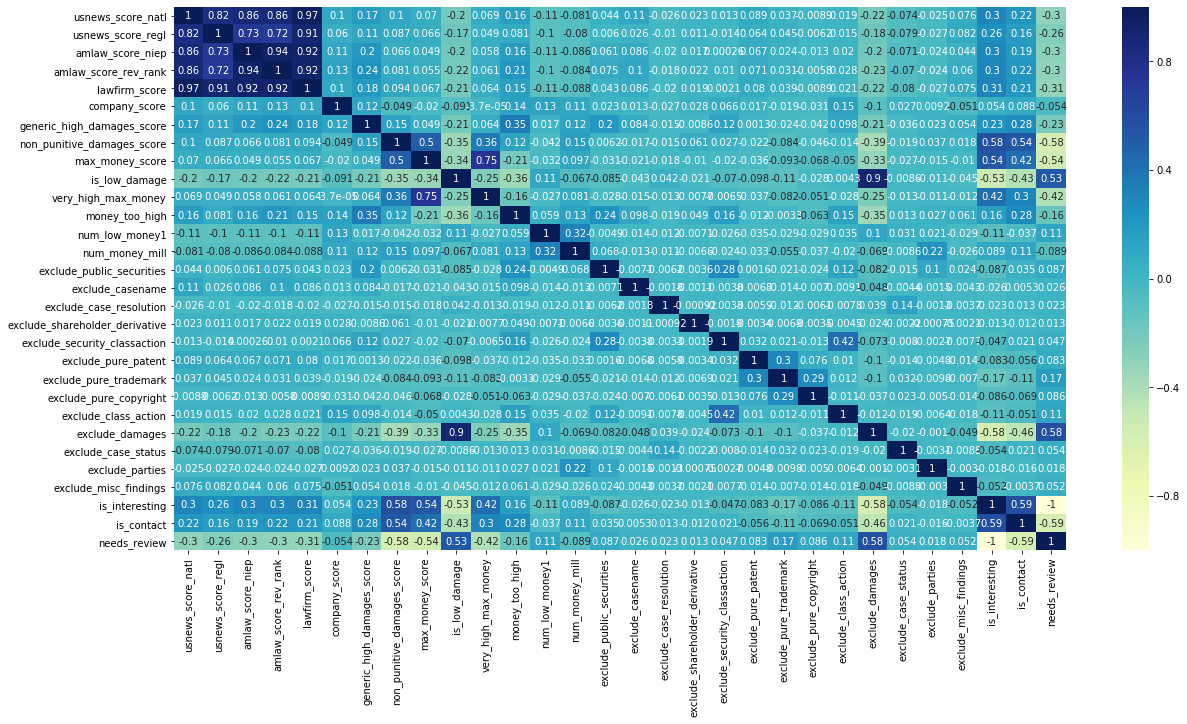

In [25]:
plt.figure(figsize=(20,10))
sns.heatmap(data_set.corr(),annot=True,cmap='YlGnBu')
plt.show()

In [26]:
data_set.corr()['is_contact']

usnews_score_natl                 0.215446
usnews_score_regl                 0.164944
amlaw_score_niep                  0.187806
amlaw_score_rev_rank              0.218352
lawfirm_score                     0.209946
company_score                     0.088428
generic_high_damages_score        0.280202
non_punitive_damages_score        0.536161
max_money_score                   0.416162
is_low_damage                    -0.429233
very_high_max_money               0.304719
money_too_high                    0.275867
num_low_money1                   -0.036624
num_money_mill                    0.109903
exclude_public_securities         0.035175
exclude_casename                  0.005288
exclude_case_resolution           0.012839
exclude_shareholder_derivative   -0.011660
exclude_security_classaction      0.021493
exclude_pure_patent              -0.056239
exclude_pure_trademark           -0.109648
exclude_pure_copyright           -0.068503
exclude_class_action             -0.050628
exclude_dam

In [27]:
data_set.drop(['needs_review','needs_review_rule','needs_review_priority'],axis=1,inplace=True)

In [28]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1884 entries, 4:19-cv-00308_E.D.Ark. to 3:17-cv-02191_N.D.Cal.
Data columns (total 30 columns):
usnews_score_natl                 1884 non-null float64
usnews_score_regl                 1884 non-null float64
amlaw_score_niep                  1884 non-null float64
amlaw_score_rev_rank              1884 non-null float64
lawfirm_score                     1884 non-null float64
company_score                     1884 non-null float64
generic_high_damages_score        1884 non-null float64
non_punitive_damages_score        1884 non-null float64
max_money_score                   1884 non-null float64
is_low_damage                     1884 non-null float64
very_high_max_money               1884 non-null float64
money_too_high                    1884 non-null float64
num_low_money1                    1884 non-null float64
num_money_mill                    1884 non-null float64
exclude_public_securities         1884 non-null float64
exclude_casename   

In [29]:
data_set.interesting_rule.value_counts()

high_profile_case            255
high_non_punitive_damages    232
generic_high_damages         166
very_high_max_money           75
high_max_money                44
Name: interesting_rule, dtype: int64

In [30]:
data_set.is_interesting.value_counts()

0.0    1430
1.0     454
Name: is_interesting, dtype: int64

### One Hot Encoding

In [31]:
dummy1 = pd.get_dummies(data_set['interesting_rule'],drop_first=True,prefix='ir_')

data_set=pd.concat([data_set,dummy1],axis=1)

data_set.drop('interesting_rule',axis=1,inplace=True)

# Putting feature variable to X
X = data_set.drop(['is_contact'], axis=1)

X.head()

,usnews_score_natl,usnews_score_regl,amlaw_score_niep,amlaw_score_rev_rank,lawfirm_score,company_score,generic_high_damages_score,non_punitive_damages_score,max_money_score,is_low_damage,...,exclude_class_action,exclude_damages,exclude_case_status,exclude_parties,exclude_misc_findings,is_interesting,ir__high_max_money,ir__high_non_punitive_damages,ir__high_profile_case,ir__very_high_max_money
fokal_key,,,,,,,,,,,,,,,,,,,,,
4:19-cv-00308_E.D.Ark.,5.0,10.0,5.0,5.0,25.0,40.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
8:18-cv-01762_C.D.Cal.,10.0,10.0,5.0,5.0,30.0,20.0,0.0,0.0,0.0,2.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0
1:19-cv-00274_W.D.Mich.,20.0,20.0,10.0,10.0,60.0,30.0,0.0,0.0,0.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0
6:18-cv-01305_D.Kan.,0.0,5.0,0.0,0.0,5.0,20.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0
2:16-cv-03739_E.D.N.Y.,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0


In [32]:
# Putting response variable to y
y = data_set['is_contact']

y.head()

fokal_key
4:19-cv-00308_E.D.Ark.     0.0
8:18-cv-01762_C.D.Cal.     0.0
1:19-cv-00274_W.D.Mich.    0.0
6:18-cv-01305_D.Kan.       0.0
2:16-cv-03739_E.D.N.Y.     0.0
Name: is_contact, dtype: float64

In [33]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100,stratify=y)

In [34]:
X_train.iloc[:,:10].head()

,usnews_score_natl,usnews_score_regl,amlaw_score_niep,amlaw_score_rev_rank,lawfirm_score,company_score,generic_high_damages_score,non_punitive_damages_score,max_money_score,is_low_damage
fokal_key,,,,,,,,,,
4:17-cv-02292_E.D.Mo.,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0
4:19-cv-01195_S.D.Tex.,0.0,10.0,0.0,0.0,10.0,50.0,0.0,0.0,0.0,2.0
8:18-cv-00492_D.Neb.,0.0,5.0,0.0,0.0,5.0,20.0,0.0,0.0,0.0,0.0
0:18-cv-03315_D.Minn.,5.0,5.0,5.0,5.0,20.0,30.0,0.0,0.0,0.0,0.0
1:17-cv-02129_N.D.Ga.,5.0,5.0,0.0,0.0,10.0,20.0,0.0,0.0,0.0,0.0


In [35]:
X_train.iloc[:,10:20].head()

,very_high_max_money,money_too_high,num_low_money1,num_money_mill,exclude_public_securities,exclude_casename,exclude_case_resolution,exclude_shareholder_derivative,exclude_security_classaction,exclude_pure_patent
fokal_key,,,,,,,,,,
4:17-cv-02292_E.D.Mo.,0.0,1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
4:19-cv-01195_S.D.Tex.,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8:18-cv-00492_D.Neb.,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
0:18-cv-03315_D.Minn.,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1:17-cv-02129_N.D.Ga.,0.0,1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
X_train.iloc[:,20:].head()

,exclude_pure_trademark,exclude_pure_copyright,exclude_class_action,exclude_damages,exclude_case_status,exclude_parties,exclude_misc_findings,is_interesting,ir__high_max_money,ir__high_non_punitive_damages,ir__high_profile_case,ir__very_high_max_money
fokal_key,,,,,,,,,,,,
4:17-cv-02292_E.D.Mo.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
4:19-cv-01195_S.D.Tex.,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0
8:18-cv-00492_D.Neb.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
0:18-cv-03315_D.Minn.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
1:17-cv-02129_N.D.Ga.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0


### Rescale Data

In [37]:
scaler = StandardScaler()

X_train= pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X.columns)

X_train.head()

,usnews_score_natl,usnews_score_regl,amlaw_score_niep,amlaw_score_rev_rank,lawfirm_score,company_score,generic_high_damages_score,non_punitive_damages_score,max_money_score,is_low_damage,...,exclude_class_action,exclude_damages,exclude_case_status,exclude_parties,exclude_misc_findings,is_interesting,ir__high_max_money,ir__high_non_punitive_damages,ir__high_profile_case,ir__very_high_max_money
fokal_key,,,,,,,,,,,,,,,,,,,,,
4:17-cv-02292_E.D.Mo.,-0.775256,-0.825292,-0.749445,-0.730061,-0.836931,-0.672002,-0.378429,-0.378292,-0.459779,-0.933954,...,-0.181426,-1.035532,-0.087437,-0.038984,-0.103616,-0.566252,-0.160253,-0.378292,-0.389997,-0.204688
4:19-cv-01195_S.D.Tex.,-0.775256,0.017587,-0.749445,-0.730061,-0.558201,2.175903,-0.378429,-0.378292,-0.459779,1.467902,...,-0.181426,0.965687,-0.087437,-0.038984,-0.103616,-0.566252,-0.160253,-0.378292,-0.389997,-0.204688
8:18-cv-00492_D.Neb.,-0.775256,-0.403853,-0.749445,-0.730061,-0.697566,-0.672002,-0.378429,-0.378292,-0.459779,-0.933954,...,-0.181426,-1.035532,-0.087437,-0.038984,-0.103616,-0.566252,-0.160253,-0.378292,-0.389997,-0.204688
0:18-cv-03315_D.Minn.,-0.416608,-0.403853,-0.010650,0.108110,-0.279470,0.277300,-0.378429,-0.378292,-0.459779,-0.933954,...,-0.181426,-1.035532,-0.087437,-0.038984,-0.103616,-0.566252,-0.160253,-0.378292,-0.389997,-0.204688
1:17-cv-02129_N.D.Ga.,-0.416608,-0.403853,-0.749445,-0.730061,-0.558201,-0.672002,-0.378429,-0.378292,-0.459779,-0.933954,...,-0.181426,-1.035532,-0.087437,-0.038984,-0.103616,-0.566252,-0.160253,-0.378292,-0.389997,-0.204688


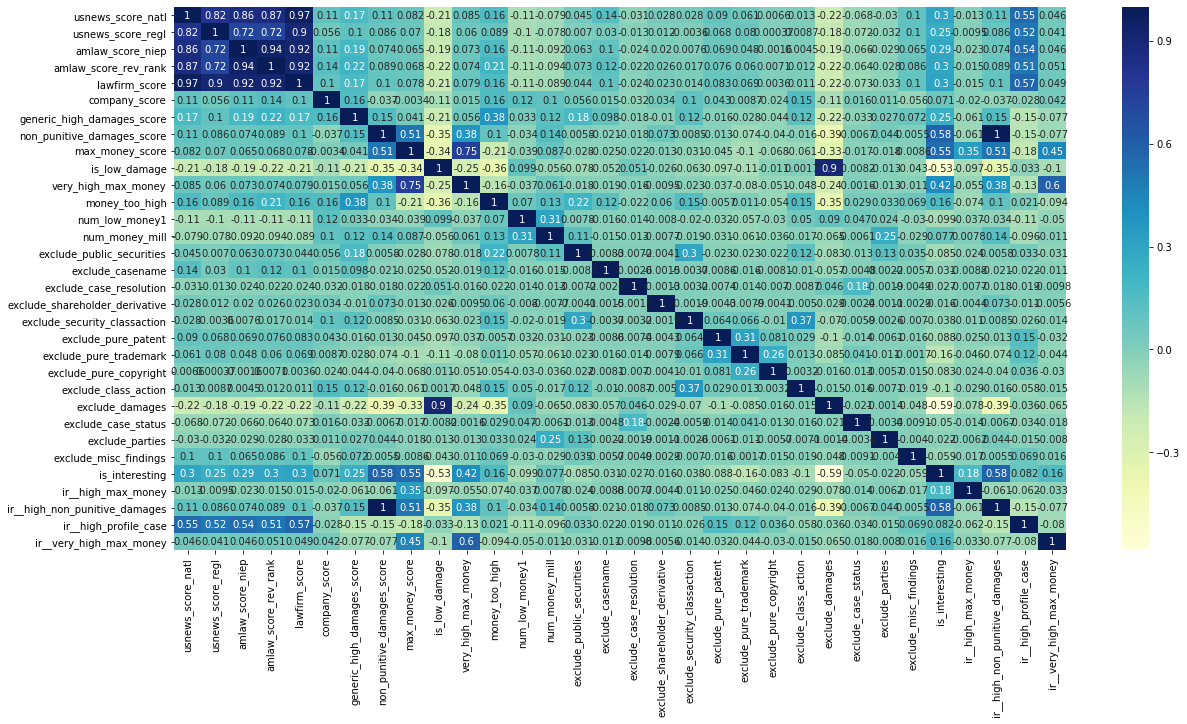

In [38]:
plt.figure(figsize=(20,10))
sns.heatmap(X_train.corr(),annot=True,cmap='YlGnBu')
plt.show()


In [39]:
# Having simple function for VIF , cross validation results and metric like accuracy sensitivity specificity recall

def get_vif(df):
    # Create a dataframe that will contain the names of all the feature variables and their respective VIFs
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

def get_model_metrics(actual,predicted):
    confusion = metrics.confusion_matrix(actual,predicted )
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    accuracy=metrics.accuracy_score(actual,predicted)
    sensitivity = TP / float(TP+FN)
    specificity = TN / float(TN+FP)
    precision=TP/float(FP+TP)
    recall=TP/float(FN+TP)
    
    precision=metrics.precision_score(actual,predicted)
    recall=metrics.recall_score(actual,predicted)
    f1=metrics.f1_score(actual,predicted, average='weighted') 
    print("Accuracy    : "+str(round(accuracy,2)))
    print("Sensitivity : "+str(round(sensitivity,2)))
    print("Specificity : "+str(round(specificity,2)))
    print("Precision   : "+str(round(precision,2)))
    print("Recall      : "+str(round(recall,2)))
    print("F1_score    : "+str(round(f1,2)))

def get_cross_validated_model_metrics(X,y,cv=5):
    accuracy=cross_val_score(logregcv, X, y, cv=cv,n_jobs=-1,scoring='accuracy')
    precision=cross_val_score(logregcv, X, y, cv=cv,n_jobs=-1,scoring='precision')
    recall=cross_val_score(logregcv, X, y, cv=cv,n_jobs=-1,scoring='recall')
    f1_weighted=cross_val_score(logregcv, X, y, cv=cv,n_jobs=-1,scoring='f1_weighted')
    roc_auc=cross_val_score(logregcv, X, y, cv=cv,n_jobs=-1,scoring='roc_auc')
    df=pd.DataFrame(
    {'accuracy': accuracy,
     'precision': precision,
     'recall': recall,
     'f1_weighted': f1_weighted,
     'roc_auc': roc_auc,
    })
    return df

# Model 1

Adding all the features and building a model

In [40]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
print(logm1.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_contact   No. Observations:                 1318
Model:                            GLM   Df Residuals:                     1287
Model Family:                Binomial   Df Model:                           30
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 07 Aug 2019   Deviance:                          nan
Time:                        17:28:23   Pearson chi2:                 1.05e+18
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [41]:
len(X_train.columns)

32

In [42]:
logregcv = LogisticRegressionCV(class_weight='balanced',cv=20)
logreg = LogisticRegression()

# RFE

Since there are too many feature we will start with Recursive Feature Elimination

In [43]:
rfe = RFE(logreg, 20)             # running RFE with all variables
rfe = rfe.fit(X_train, y_train)
rfe_df=pd.DataFrame(zip(X_train.columns,rfe.support_,rfe.ranking_),columns=['Features','Important','Rank']).sort_values('Rank')
col = X_train.columns[rfe.support_]
rfe_df

,Features,Important,Rank
0,usnews_score_natl,True,1
17,exclude_shareholder_derivative,True,1
16,exclude_case_resolution,True,1
22,exclude_class_action,True,1
23,exclude_damages,True,1
25,exclude_parties,True,1
27,is_interesting,True,1
11,money_too_high,True,1
10,very_high_max_money,True,1
9,is_low_damage,True,1


In [44]:
col

Index(['usnews_score_natl', 'amlaw_score_niep', 'amlaw_score_rev_rank',
       'company_score', 'generic_high_damages_score',
       'non_punitive_damages_score', 'max_money_score', 'is_low_damage',
       'very_high_max_money', 'money_too_high', 'exclude_case_resolution',
       'exclude_shareholder_derivative', 'exclude_pure_patent',
       'exclude_pure_trademark', 'exclude_class_action', 'exclude_damages',
       'exclude_parties', 'is_interesting', 'ir__high_max_money',
       'ir__high_non_punitive_damages'],
      dtype='object')

# Model 2

Building Logistic Regression Model Features based on RFE

In [45]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_contact   No. Observations:                 1318
Model:                            GLM   Df Residuals:                     1298
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 07 Aug 2019   Deviance:                          nan
Time:                        17:28:23   Pearson chi2:                 1.06e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [46]:
y_train_pred = res.predict(X_train_sm)
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred_final = pd.DataFrame({'is_contact':y_train.values, 'is_contact_Prob':y_train_pred})
y_train_pred_final['fokal_key'] = y_train.index
y_train_pred_final['predicted'] = y_train_pred_final.is_contact_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,is_contact,is_contact_Prob,fokal_key,predicted
0,0.0,0.251811,4:17-cv-02292_E.D.Mo.,0
1,0.0,0.010437,4:19-cv-01195_S.D.Tex.,0
2,0.0,0.068344,8:18-cv-00492_D.Neb.,0
3,0.0,0.078989,0:18-cv-03315_D.Minn.,0
4,0.0,0.274913,1:17-cv-02129_N.D.Ga.,0


In [47]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.is_contact, y_train_pred_final.predicted )
print(confusion)

[[987  62]
 [ 87 182]]


In [48]:
# Check for the VIF values of the feature variables. 
get_vif(X_train[col])

,Features,VIF
19,ir__high_non_punitive_damages,inf
5,non_punitive_damages_score,inf
2,amlaw_score_rev_rank,10.302296
1,amlaw_score_niep,9.856554
15,exclude_damages,6.106960
7,is_low_damage,5.670580
6,max_money_score,5.149006
0,usnews_score_natl,4.415096
8,very_high_max_money,3.206196
17,is_interesting,2.783479


In [49]:
y_train_pred = res.predict(X_train_sm)
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred_final = pd.DataFrame({'is_contact':y_train.values, 'is_contact_Prob':y_train_pred})
y_train_pred_final['fokal_key'] = y_train.index
y_train_pred_final['predicted'] = y_train_pred_final.is_contact_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,is_contact,is_contact_Prob,fokal_key,predicted
0,0.0,0.251811,4:17-cv-02292_E.D.Mo.,0
1,0.0,0.010437,4:19-cv-01195_S.D.Tex.,0
2,0.0,0.068344,8:18-cv-00492_D.Neb.,0
3,0.0,0.078989,0:18-cv-03315_D.Minn.,0
4,0.0,0.274913,1:17-cv-02129_N.D.Ga.,0


In [50]:
get_model_metrics(y_train_pred_final.is_contact, y_train_pred_final.predicted)

Accuracy    : 0.89
Sensitivity : 0.68
Specificity : 0.94
Precision   : 0.75
Recall      : 0.68
F1_score    : 0.88


In [51]:
cross_validated_metrics=get_cross_validated_model_metrics(X_train[col], y_train)

In [52]:
cross_validated_metrics.mean()

accuracy       0.852787
precision      0.604979
recall         0.802865
f1_weighted    0.859885
roc_auc        0.915361
dtype: float64

In [53]:
cross_validated_metrics

,accuracy,precision,recall,f1_weighted,roc_auc
0,0.848485,0.597222,0.796296,0.855915,0.918034
1,0.852273,0.600000,0.833333,0.860409,0.914021
2,0.840909,0.588235,0.740741,0.847294,0.913404
3,0.882576,0.661972,0.870370,0.888084,0.943695
4,0.839695,0.577465,0.773585,0.847723,0.887650


Binging p value to less than 0.05. Anything greater than 0.05 is insignificant to the model.

# Model 3

In [54]:
if 'exclude_pure_patent' in col:
    col=col.drop('exclude_damages')

col

Index(['usnews_score_natl', 'amlaw_score_niep', 'amlaw_score_rev_rank',
       'company_score', 'generic_high_damages_score',
       'non_punitive_damages_score', 'max_money_score', 'is_low_damage',
       'very_high_max_money', 'money_too_high', 'exclude_case_resolution',
       'exclude_shareholder_derivative', 'exclude_pure_patent',
       'exclude_pure_trademark', 'exclude_class_action', 'exclude_parties',
       'is_interesting', 'ir__high_max_money',
       'ir__high_non_punitive_damages'],
      dtype='object')

In [55]:
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_contact   No. Observations:                 1318
Model:                            GLM   Df Residuals:                     1299
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 07 Aug 2019   Deviance:                          nan
Time:                        17:28:46   Pearson chi2:                 1.07e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

Binging p value to less than 0.05. Anything greater than 0.05 is insignificant to the model.

In [56]:
if 'very_high_max_money' in col:
    col=col.drop('very_high_max_money')

In [57]:
X_train_sm = sm.add_constant(X_train[col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_contact   No. Observations:                 1318
Model:                            GLM   Df Residuals:                     1300
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 07 Aug 2019   Deviance:                          nan
Time:                        17:28:46   Pearson chi2:                 1.07e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

Binging p value to less than 0.05. Anything greater than 0.05 is insignificant to the model.

In [58]:

if 'exclude_pure_trademark' in col:
    col=col.drop('exclude_pure_trademark')

In [59]:
X_train_sm = sm.add_constant(X_train[col])
logm5 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm5.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_contact   No. Observations:                 1318
Model:                            GLM   Df Residuals:                     1301
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 07 Aug 2019   Deviance:                          nan
Time:                        17:28:47   Pearson chi2:                 1.10e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

Binging p value to less than 0.05. Anything greater than 0.05 is insignificant to the model.

In [60]:

if 'amlaw_score_rev_rank' in col:
    col=col.drop('amlaw_score_rev_rank')


In [61]:
X_train_sm = sm.add_constant(X_train[col])
logm = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_contact   No. Observations:                 1318
Model:                            GLM   Df Residuals:                     1302
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 07 Aug 2019   Deviance:                          nan
Time:                        17:28:47   Pearson chi2:                 1.11e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

Binging p value to less than 0.05. Anything greater than 0.05 is insignificant to the model.

In [62]:

if 'ir__high_max_money' in col:
    col=col.drop('ir__high_max_money')

In [63]:
X_train_sm = sm.add_constant(X_train[col])
logm = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_contact   No. Observations:                 1318
Model:                            GLM   Df Residuals:                     1303
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 07 Aug 2019   Deviance:                          nan
Time:                        17:28:47   Pearson chi2:                 1.10e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

Binging p value to less than 0.05. Anything greater than 0.05 is insignificant to the model.

In [64]:
if 'amlaw_score_niep' in col:
    col=col.drop('amlaw_score_niep')

In [65]:
X_train_sm = sm.add_constant(X_train[col])
logm = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_contact   No. Observations:                 1318
Model:                            GLM   Df Residuals:                     1304
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 07 Aug 2019   Deviance:                          nan
Time:                        17:28:47   Pearson chi2:                 1.13e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [66]:
# numbers changes

Binging p value to less than 0.05. Anything greater than 0.05 is insignificant to the model.

In [67]:
# Check for the VIF values of the feature variables. 
get_vif(X_train[col])

,Features,VIF
3,non_punitive_damages_score,inf
13,ir__high_non_punitive_damages,inf
12,is_interesting,2.378416
4,max_money_score,1.925929
5,is_low_damage,1.686378
6,money_too_high,1.608700
2,generic_high_damages_score,1.246195
0,usnews_score_natl,1.155167
10,exclude_class_action,1.078627
1,company_score,1.078595


In [68]:
if 'non_punitive_damages_score' in col:
    col=col.drop('non_punitive_damages_score')

In [69]:
X_train_sm = sm.add_constant(X_train[col])
logm = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_contact   No. Observations:                 1318
Model:                            GLM   Df Residuals:                     1304
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -358.81
Date:                Wed, 07 Aug 2019   Deviance:                       717.61
Time:                        17:28:47   Pearson chi2:                 1.14e+03
No. Iterations:                    20                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

Binging p value to less than 0.05. Anything greater than 0.05 is insignificant to the model.

In [70]:
if 'exclude_parties' in col:
    col=col.drop('exclude_parties')

In [71]:
X_train_sm = sm.add_constant(X_train[col])
logm = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_contact   No. Observations:                 1318
Model:                            GLM   Df Residuals:                     1305
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -359.99
Date:                Wed, 07 Aug 2019   Deviance:                       719.98
Time:                        17:28:47   Pearson chi2:                 1.14e+03
No. Iterations:                    19                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [72]:
if 'exclude_shareholder_derivative' in col:
    col=col.drop('exclude_shareholder_derivative')

In [73]:
X_train_sm = sm.add_constant(X_train[col])
logm = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_contact   No. Observations:                 1318
Model:                            GLM   Df Residuals:                     1306
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -361.12
Date:                Wed, 07 Aug 2019   Deviance:                       722.24
Time:                        17:28:47   Pearson chi2:                 1.14e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [74]:
if 'exclude_class_action' in col:
    col=col.drop('exclude_class_action')

In [75]:
X_train_sm = sm.add_constant(X_train[col])
logm = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_contact   No. Observations:                 1318
Model:                            GLM   Df Residuals:                     1307
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -363.10
Date:                Wed, 07 Aug 2019   Deviance:                       726.20
Time:                        17:28:47   Pearson chi2:                 1.15e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [76]:
# Check for the VIF values of the feature variables. 
get_vif(X_train[col])

,Features,VIF
8,is_interesting,2.304300
3,max_money_score,1.920491
9,ir__high_non_punitive_damages,1.708172
4,is_low_damage,1.684931
5,money_too_high,1.581604
2,generic_high_damages_score,1.236396
0,usnews_score_natl,1.152526
7,exclude_pure_patent,1.061062
1,company_score,1.056944
6,exclude_case_resolution,1.003814


In [77]:
# if 'is_low_damage' in col:
#     col=col.drop('is_low_damage')
# X_train_sm = sm.add_constant(X_train[col])
# logm = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
# res = logm.fit()
# print(res.summary())

All the feature are now acceptable range of p value.

In [78]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

fokal_key
4:17-cv-02292_E.D.Mo.     0.206974
4:19-cv-01195_S.D.Tex.    0.007917
8:18-cv-00492_D.Neb.      0.057641
0:18-cv-03315_D.Minn.     0.068812
1:17-cv-02129_N.D.Ga.     0.216586
4:07-cv-00194_S.D.Iowa    0.042562
4:14-cv-00401_W.D.Mo.     0.021105
5:18-cv-00010_N.D.Fla.    0.005666
5:19-cv-00051_W.D.N.C.    0.068812
1:14-cv-02590_S.D.N.Y.    0.376473
dtype: float64

In [79]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.206974  , 0.0079173 , 0.05764147, 0.06881228, 0.2165856 ,
       0.04256162, 0.02110517, 0.00566592, 0.06881228, 0.37647334])

In [80]:
y_train_pred_final = pd.DataFrame({'is_contact':y_train.values, 'is_contact_Prob':y_train_pred})
y_train_pred_final['fokal_key'] = y_train.index
y_train_pred_final.head()

,is_contact,is_contact_Prob,fokal_key
0,0.0,0.206974,4:17-cv-02292_E.D.Mo.
1,0.0,0.007917,4:19-cv-01195_S.D.Tex.
2,0.0,0.057641,8:18-cv-00492_D.Neb.
3,0.0,0.068812,0:18-cv-03315_D.Minn.
4,0.0,0.216586,1:17-cv-02129_N.D.Ga.


In [81]:
y_train_pred_final['predicted'] = y_train_pred_final.is_contact_Prob.map(lambda x: 1 if x > 0.21 else 0)

# Let's see the head
y_train_pred_final.head()

,is_contact,is_contact_Prob,fokal_key,predicted
0,0.0,0.206974,4:17-cv-02292_E.D.Mo.,0
1,0.0,0.007917,4:19-cv-01195_S.D.Tex.,0
2,0.0,0.057641,8:18-cv-00492_D.Neb.,0
3,0.0,0.068812,0:18-cv-03315_D.Minn.,0
4,0.0,0.216586,1:17-cv-02129_N.D.Ga.,1


In [82]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.is_contact, y_train_pred_final.predicted )
print(confusion)

[[872 177]
 [ 33 236]]


In [83]:
get_model_metrics(y_train_pred_final.is_contact, y_train_pred_final.predicted)

Accuracy    : 0.84
Sensitivity : 0.88
Specificity : 0.83
Precision   : 0.57
Recall      : 0.88
F1_score    : 0.85


In [84]:
cross_validated_metrics=get_cross_validated_model_metrics(X_train[col],y_train,cv=5)

In [85]:
cross_validated_metrics

,accuracy,precision,recall,f1_weighted,roc_auc
0,0.852273,0.605634,0.796296,0.859202,0.923060
1,0.848485,0.594595,0.814815,0.856534,0.913404
2,0.840909,0.585714,0.759259,0.848023,0.913933
3,0.890152,0.676056,0.888889,0.895304,0.949868
4,0.824427,0.547945,0.754717,0.833950,0.896994


In [86]:
cross_validated_metrics.mean()

accuracy       0.851249
precision      0.601989
recall         0.802795
f1_weighted    0.858603
roc_auc        0.919452
dtype: float64

In [87]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.is_contact, y_train_pred_final.predicted))

0.8406676783004552


In [88]:
# Check for the VIF values of the feature variables. 
get_vif(X_train[col])

,Features,VIF
8,is_interesting,2.304300
3,max_money_score,1.920491
9,ir__high_non_punitive_damages,1.708172
4,is_low_damage,1.684931
5,money_too_high,1.581604
2,generic_high_damages_score,1.236396
0,usnews_score_natl,1.152526
7,exclude_pure_patent,1.061062
1,company_score,1.056944
6,exclude_case_resolution,1.003814


# Model

In [89]:
if 'non_punitive_damages_scoreexclude_pure_patent' in col:
    col=col.drop('non_punitive_damages_score')

In [90]:
X_train_sm = sm.add_constant(X_train[col])
logm = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_contact   No. Observations:                 1318
Model:                            GLM   Df Residuals:                     1307
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -363.10
Date:                Wed, 07 Aug 2019   Deviance:                       726.20
Time:                        17:28:59   Pearson chi2:                 1.15e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [91]:
get_vif(X_train[col])

,Features,VIF
8,is_interesting,2.304300
3,max_money_score,1.920491
9,ir__high_non_punitive_damages,1.708172
4,is_low_damage,1.684931
5,money_too_high,1.581604
2,generic_high_damages_score,1.236396
0,usnews_score_natl,1.152526
7,exclude_pure_patent,1.061062
1,company_score,1.056944
6,exclude_case_resolution,1.003814


In [92]:
logreg = LogisticRegressionCV(class_weight='balanced',cv=20)

In [93]:
logreg

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=20, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [94]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

fokal_key
4:17-cv-02292_E.D.Mo.     0.206974
4:19-cv-01195_S.D.Tex.    0.007917
8:18-cv-00492_D.Neb.      0.057641
0:18-cv-03315_D.Minn.     0.068812
1:17-cv-02129_N.D.Ga.     0.216586
4:07-cv-00194_S.D.Iowa    0.042562
4:14-cv-00401_W.D.Mo.     0.021105
5:18-cv-00010_N.D.Fla.    0.005666
5:19-cv-00051_W.D.N.C.    0.068812
1:14-cv-02590_S.D.N.Y.    0.376473
dtype: float64

In [95]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.206974  , 0.0079173 , 0.05764147, 0.06881228, 0.2165856 ,
       0.04256162, 0.02110517, 0.00566592, 0.06881228, 0.37647334])

In [96]:
y_train_pred_final = pd.DataFrame({'is_contact':y_train.values, 'is_contact_Prob':y_train_pred})
y_train_pred_final['fokal_key'] = y_train.index
y_train_pred_final.head()

,is_contact,is_contact_Prob,fokal_key
0,0.0,0.206974,4:17-cv-02292_E.D.Mo.
1,0.0,0.007917,4:19-cv-01195_S.D.Tex.
2,0.0,0.057641,8:18-cv-00492_D.Neb.
3,0.0,0.068812,0:18-cv-03315_D.Minn.
4,0.0,0.216586,1:17-cv-02129_N.D.Ga.


In [97]:
y_train_pred_final['predicted'] = y_train_pred_final.is_contact_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,is_contact,is_contact_Prob,fokal_key,predicted
0,0.0,0.206974,4:17-cv-02292_E.D.Mo.,0
1,0.0,0.007917,4:19-cv-01195_S.D.Tex.,0
2,0.0,0.057641,8:18-cv-00492_D.Neb.,0
3,0.0,0.068812,0:18-cv-03315_D.Minn.,0
4,0.0,0.216586,1:17-cv-02129_N.D.Ga.,0


In [98]:
y_train_pred_final.head()

,is_contact,is_contact_Prob,fokal_key,predicted
0,0.0,0.206974,4:17-cv-02292_E.D.Mo.,0
1,0.0,0.007917,4:19-cv-01195_S.D.Tex.,0
2,0.0,0.057641,8:18-cv-00492_D.Neb.,0
3,0.0,0.068812,0:18-cv-03315_D.Minn.,0
4,0.0,0.216586,1:17-cv-02129_N.D.Ga.,0


In [99]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.is_contact, y_train_pred_final.predicted )
print(confusion)

[[982  67]
 [ 80 189]]


In [100]:
get_model_metrics(y_train_pred_final.is_contact, y_train_pred_final.predicted)

Accuracy    : 0.89
Sensitivity : 0.7
Specificity : 0.94
Precision   : 0.74
Recall      : 0.7
F1_score    : 0.89


In [101]:
cross_validated_metrics=get_cross_validated_model_metrics(X_train[col],y_train,cv=5)

In [102]:
cross_validated_metrics

,accuracy,precision,recall,f1_weighted,roc_auc
0,0.852273,0.605634,0.796296,0.859202,0.923060
1,0.848485,0.594595,0.814815,0.856534,0.913404
2,0.840909,0.585714,0.759259,0.848023,0.913933
3,0.890152,0.676056,0.888889,0.895304,0.949868
4,0.824427,0.547945,0.754717,0.833950,0.896994


In [103]:
cross_validated_metrics.mean()

accuracy       0.851249
precision      0.601989
recall         0.802795
f1_weighted    0.858603
roc_auc        0.919452
dtype: float64

In [104]:
cross_validated_metrics=get_cross_validated_model_metrics(X_train[col],y_train,cv=10)

In [105]:
cross_validated_metrics

,accuracy,precision,recall,f1_weighted,roc_auc
0,0.848485,0.594595,0.814815,0.856534,0.940212
1,0.848485,0.600000,0.777778,0.855260,0.912169
2,0.848485,0.589744,0.851852,0.857668,0.911464
3,0.840909,0.583333,0.777778,0.848711,0.908818
4,0.848485,0.606061,0.740741,0.853832,0.913757
5,0.825758,0.552632,0.777778,0.835685,0.911464
6,0.924242,0.757576,0.925926,0.926916,0.963139
7,0.848485,0.585366,0.888889,0.858671,0.936155
8,0.825758,0.558824,0.703704,0.832751,0.914991
9,0.815385,0.525000,0.807692,0.828304,0.885910


In [106]:
cross_validated_metrics.mean()

accuracy       0.847448
precision      0.595313
recall         0.806695
f1_weighted    0.855433
roc_auc        0.919808
dtype: float64

In [107]:
# Check for the VIF values of the feature variables. 


In [108]:
get_vif(X_train[col])

,Features,VIF
8,is_interesting,2.304300
3,max_money_score,1.920491
9,ir__high_non_punitive_damages,1.708172
4,is_low_damage,1.684931
5,money_too_high,1.581604
2,generic_high_damages_score,1.236396
0,usnews_score_natl,1.152526
7,exclude_pure_patent,1.061062
1,company_score,1.056944
6,exclude_case_resolution,1.003814


### Step 9: Plotting the ROC Curve

An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [109]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [110]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.is_contact, y_train_pred_final.is_contact_Prob, drop_intermediate = False )

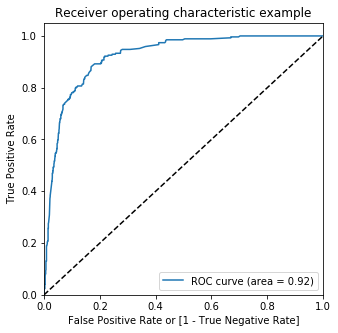

In [111]:
draw_roc(y_train_pred_final.is_contact, y_train_pred_final.is_contact_Prob)

### Step 10: Finding Optimal Cutoff Point

Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [112]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.is_contact_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,is_contact,is_contact_Prob,fokal_key,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.0,0.206974,4:17-cv-02292_E.D.Mo.,0,1,1,1,0,0,0,0,0,0,0
1,0.0,0.007917,4:19-cv-01195_S.D.Tex.,0,1,0,0,0,0,0,0,0,0,0
2,0.0,0.057641,8:18-cv-00492_D.Neb.,0,1,0,0,0,0,0,0,0,0,0
3,0.0,0.068812,0:18-cv-03315_D.Minn.,0,1,0,0,0,0,0,0,0,0,0
4,0.0,0.216586,1:17-cv-02129_N.D.Ga.,0,1,1,1,0,0,0,0,0,0,0


In [113]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])


# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.is_contact, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.204097  1.000000  0.000000
0.1   0.1  0.808042  0.921933  0.778837
0.2   0.2  0.827011  0.892193  0.810296
0.3   0.3  0.869499  0.788104  0.890372
0.4   0.4  0.879363  0.754647  0.911344
0.5   0.5  0.888467  0.702602  0.936130
0.6   0.6  0.874052  0.557621  0.955195
0.7   0.7  0.867223  0.472119  0.968541
0.8   0.8  0.827769  0.208178  0.986654
0.9   0.9  0.799697  0.026022  0.998093


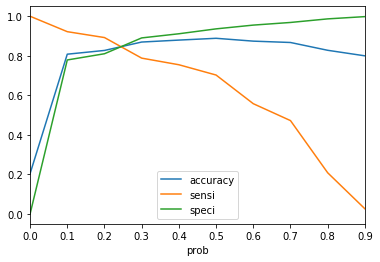

In [114]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [115]:
y_train_pred_final['final_predicted'] = y_train_pred_final.is_contact_Prob.map( lambda x: 1 if x > 0.3 else 0)

y_train_pred_final.head()

,is_contact,is_contact_Prob,fokal_key,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0.0,0.206974,4:17-cv-02292_E.D.Mo.,0,1,1,1,0,0,0,0,0,0,0,0
1,0.0,0.007917,4:19-cv-01195_S.D.Tex.,0,1,0,0,0,0,0,0,0,0,0,0
2,0.0,0.057641,8:18-cv-00492_D.Neb.,0,1,0,0,0,0,0,0,0,0,0,0
3,0.0,0.068812,0:18-cv-03315_D.Minn.,0,1,0,0,0,0,0,0,0,0,0,0
4,0.0,0.216586,1:17-cv-02129_N.D.Ga.,0,1,1,1,0,0,0,0,0,0,0,0


In [116]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.is_contact, y_train_pred_final.final_predicted)

0.8694992412746586

In [117]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.is_contact, y_train_pred_final.final_predicted )
confusion2

array([[934, 115],
       [ 57, 212]])

In [118]:
res.params

const                           -2.546473
usnews_score_natl                0.160567
company_score                    0.138500
generic_high_damages_score       0.195063
max_money_score                  0.581745
is_low_damage                   -1.012154
money_too_high                   0.551616
exclude_case_resolution          0.193292
exclude_pure_patent             -0.319773
is_interesting                   0.457555
ir__high_non_punitive_damages    0.425985
dtype: float64

In [119]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.is_contact, y_train_pred_final.final_predicted)

0.8694992412746586

In [120]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.is_contact, y_train_pred_final.final_predicted )
confusion2

array([[934, 115],
       [ 57, 212]])

In [121]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [122]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7881040892193308

In [123]:
# Let us calculate specificity
TN / float(TN+FP)

0.8903717826501429

In [124]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.109628217349857


In [125]:
# Positive predictive value 
print (TP / float(TP+FP))

0.6483180428134556


In [126]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9424823410696267


## Precision and Recall

In [127]:
confusion = metrics.confusion_matrix(y_train_pred_final.is_contact, y_train_pred_final.predicted )
confusion

array([[982,  67],
       [ 80, 189]])

In [128]:
confusion[1,1]/float(confusion[0,1]+confusion[1,1])

0.73828125

In [129]:
confusion[1,1]/float(confusion[1,0]+confusion[1,1])

0.7026022304832714

In [130]:
metrics.precision_score(y_train_pred_final.is_contact, y_train_pred_final.predicted)

0.73828125

In [131]:
metrics.recall_score(y_train_pred_final.is_contact, y_train_pred_final.predicted)

0.7026022304832714

### Precision and recall tradeoff

In [132]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.is_contact, y_train_pred_final.is_contact_Prob)

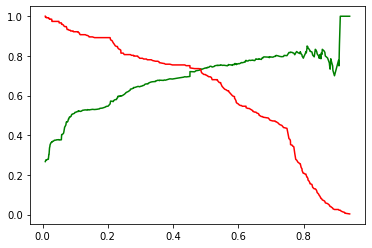

In [133]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [134]:
y_train_pred_final['final_predicted'] = y_train_pred_final.is_contact_Prob.map( lambda x: 1 if x > 0.4 else 0)

y_train_pred_final.head()

,is_contact,is_contact_Prob,fokal_key,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0.0,0.206974,4:17-cv-02292_E.D.Mo.,0,1,1,1,0,0,0,0,0,0,0,0
1,0.0,0.007917,4:19-cv-01195_S.D.Tex.,0,1,0,0,0,0,0,0,0,0,0,0
2,0.0,0.057641,8:18-cv-00492_D.Neb.,0,1,0,0,0,0,0,0,0,0,0,0
3,0.0,0.068812,0:18-cv-03315_D.Minn.,0,1,0,0,0,0,0,0,0,0,0,0
4,0.0,0.216586,1:17-cv-02129_N.D.Ga.,0,1,1,1,0,0,0,0,0,0,0,0


In [135]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.is_contact, y_train_pred_final.final_predicted)

0.8793626707132018

In [136]:
confusion3 = metrics.confusion_matrix(y_train_pred_final.is_contact, y_train_pred_final.final_predicted )
confusion3

array([[956,  93],
       [ 66, 203]])

# Checkpoint : Confusion matrix 

In [137]:
confusion    # threshold 0.5

array([[982,  67],
       [ 80, 189]])

In [138]:
confusion2  # threshold 0.3

array([[934, 115],
       [ 57, 212]])

In [139]:
confusion3 # threshold 0.4

array([[956,  93],
       [ 66, 203]])

In [140]:
### Step 11: Making predictions on the test set

In [141]:
X_test = X_test[col]
X_test.head()

,usnews_score_natl,company_score,generic_high_damages_score,max_money_score,is_low_damage,money_too_high,exclude_case_resolution,exclude_pure_patent,is_interesting,ir__high_non_punitive_damages
fokal_key,,,,,,,,,,
3:19-cv-01163_N.D.Cal.,10.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1:15-cv-06133_N.D.Ill.,10.0,20.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1:18-cv-05361_S.D.N.Y.,5.0,60.0,20.0,0.0,0.0,1.0,0.0,0.0,1.0,0
5:18-cv-00299_W.D.Okla.,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3:16-cv-02674_D.P.R.,0.0,20.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1


In [142]:
scaler = StandardScaler()

X_test= pd.DataFrame(scaler.fit_transform(X_test), index=X_test.index, columns=X_test.columns)

X_test.head()

,usnews_score_natl,company_score,generic_high_damages_score,max_money_score,is_low_damage,money_too_high,exclude_case_resolution,exclude_pure_patent,is_interesting,ir__high_non_punitive_damages
fokal_key,,,,,,,,,,
3:19-cv-01163_N.D.Cal.,-0.085281,0.289685,-0.361204,-0.411608,-0.928406,-0.499448,0.0,-0.127114,-0.556943,-0.366427
1:15-cv-06133_N.D.Ill.,-0.085281,-0.658070,-0.361204,-0.411608,-0.928406,2.002211,0.0,-0.127114,-0.556943,-0.366427
1:18-cv-05361_S.D.N.Y.,-0.435056,3.132949,1.910368,-0.411608,-0.928406,2.002211,0.0,-0.127114,1.795517,-0.366427
5:18-cv-00299_W.D.Okla.,-0.784831,-0.658070,-0.361204,-0.411608,-0.928406,-0.499448,0.0,-0.127114,-0.556943,-0.366427
3:16-cv-02674_D.P.R.,-0.784831,-0.658070,-0.361204,-0.411608,-0.928406,2.002211,0.0,-0.127114,1.795517,2.729059


In [143]:
X_test_sm = sm.add_constant(X_test)

In [144]:
y_test_pred = res.predict(X_test_sm)

In [145]:
y_test_pred[:10]

fokal_key
3:19-cv-01163_N.D.Cal.     0.073370
1:15-cv-06133_N.D.Ill.     0.216301
1:18-cv-05361_S.D.N.Y.     0.668414
5:18-cv-00299_W.D.Okla.    0.058435
3:16-cv-02674_D.P.R.       0.730140
1:17-cv-01147_W.D.Tex.     0.005743
2:18-cv-00712_N.D.Ala.     0.005743
5:19-cv-00549_N.D.Ohio     0.021133
1:18-cv-01831_S.D.N.Y.     0.572927
1:18-cv-00746_M.D.N.C.     0.005743
dtype: float64

In [146]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [147]:
# Let's see the head
y_pred_1.head()

,0
fokal_key,
3:19-cv-01163_N.D.Cal.,0.073370
1:15-cv-06133_N.D.Ill.,0.216301
1:18-cv-05361_S.D.N.Y.,0.668414
5:18-cv-00299_W.D.Okla.,0.058435
3:16-cv-02674_D.P.R.,0.730140


In [148]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [149]:
# Putting CustID to index
y_test_df['fokal_key'] = y_test_df.index

In [150]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [151]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [152]:
y_pred_final.head()

,is_contact,fokal_key,0
0,1.0,3:19-cv-01163_N.D.Cal.,0.073370
1,1.0,1:15-cv-06133_N.D.Ill.,0.216301
2,0.0,1:18-cv-05361_S.D.N.Y.,0.668414
3,0.0,5:18-cv-00299_W.D.Okla.,0.058435
4,1.0,3:16-cv-02674_D.P.R.,0.730140


In [153]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'is_contact_Prob'})

In [154]:
# Rearranging the columns
y_pred_final = y_pred_final.reindex_axis(['fokal_key','is_contact','is_contact_Prob'], axis=1)

In [155]:
# Let's see the head of y_pred_final
y_pred_final.head()

,fokal_key,is_contact,is_contact_Prob
0,3:19-cv-01163_N.D.Cal.,1.0,0.073370
1,1:15-cv-06133_N.D.Ill.,1.0,0.216301
2,1:18-cv-05361_S.D.N.Y.,0.0,0.668414
3,5:18-cv-00299_W.D.Okla.,0.0,0.058435
4,3:16-cv-02674_D.P.R.,1.0,0.730140


In [156]:
y_pred_final['final_predicted'] = y_pred_final.is_contact_Prob.map(lambda x: 1 if x > 0.4 else 0)

In [157]:
y_pred_final.head()

,fokal_key,is_contact,is_contact_Prob,final_predicted
0,3:19-cv-01163_N.D.Cal.,1.0,0.073370,0
1,1:15-cv-06133_N.D.Ill.,1.0,0.216301,0
2,1:18-cv-05361_S.D.N.Y.,0.0,0.668414,1
3,5:18-cv-00299_W.D.Okla.,0.0,0.058435,0
4,3:16-cv-02674_D.P.R.,1.0,0.730140,1


In [158]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.is_contact, y_pred_final.final_predicted)

0.8763250883392226

In [159]:
confusion_test_2 = metrics.confusion_matrix(y_pred_final.is_contact, y_pred_final.final_predicted )
confusion_test_2

array([[410,  41],
       [ 29,  86]])

In [160]:
TP = confusion_test_2[1,1] # true positive 
TN = confusion_test_2[0,0] # true negatives
FP = confusion_test_2[0,1] # false positives
FN = confusion_test_2[1,0] # false negatives

In [161]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7478260869565218

In [162]:
# Let us calculate specificity
TN / float(TN+FP)

0.9090909090909091

# Test the data on entire data set

In [163]:
consolidated_ic_debug_df=pd.read_csv('./debug.csv')

In [164]:
consolidated_ic_debug_df.shape

(18741, 161)

In [165]:
consolidated_ic_debug_df.head()

,10_k,10_k_signed,Civil Action Number,Field of Law,Judicial Officers,Product Liability Findings,antitrust,antitrust_findings,attorney,attorney_defendant,...,exclude_damages,exclude_case_status,exclude_parties,exclude_misc_findings,exclude_flags,is_interesting,interesting_rule,needs_review,needs_review_rule,needs_review_priority
0,False,False,NaN,NaN,NaN,NaN,0.0,NaN,"isaac d, shun isaac d‘ shut! texas bar no. 240...",NaN,...,0,0,0.0,0.0,NaN,0.0,NaN,1.0,high_max_money,low
1,False,False,NaN,NaN,NaN,NaN,0.0,NaN,NaN,Heather Anne Kabele,...,1,0,0.0,0.0,"class_action,low_damages",0.0,NaN,1.0,high_profile_company,low
2,False,False,NaN,NaN,NaN,NaN,0.0,NaN,"michael j. abramx michael j. abrams, ks #15407...",Anne M. Kindling\r\nNathan David Dupes,...,1,0,0.0,0.0,low_damages,0.0,NaN,1.0,high_profile_company,low
3,False,False,NaN,NaN,NaN,NaN,0.0,NaN,NaN,Travis John Ternes,...,1,0,0.0,0.0,low_damages,0.0,NaN,1.0,high_profile_company,low
4,False,False,NaN,NaN,NaN,NaN,0.0,NaN,"sumeer kakar sumeer kakar, esq. kalpana nagamp...","John Harry Gionis , Elizabeth Erin Schlissel",...,1,0,0.0,0.0,low_damages,0.0,NaN,1.0,high_profile_company,low


In [166]:
df=consolidated_ic_debug_df[['fokal_key',
 'usnews_score_natl',
 'usnews_score_regl',
 'amlaw_score_niep',
 'amlaw_score_rev_rank',
 'lawfirm_score',
 'company_score',
 'generic_high_damages_score',
 'non_punitive_damages_score',
 'max_money_score',
 'is_low_damage',
 'very_high_max_money',
 'money_too_high',
 'num_low_money1',
 'num_money_mill',
 'exclude_public_securities',
 'exclude_casename',
 'exclude_case_resolution',
 'exclude_shareholder_derivative',
 'exclude_security_classaction',
 'exclude_pure_patent',
 'exclude_pure_trademark',
 'exclude_pure_copyright',
 'exclude_class_action',
 'exclude_damages',
 'exclude_case_status',
 'exclude_parties',
 'exclude_misc_findings',
 'exclude_flags',
 'is_interesting',
 'is_contact',
 'interesting_rule',
 'needs_review',
 'needs_review_rule',
 'needs_review_priority']]

In [167]:
# prepare the entire set of data to run on model
# Set index
# get dummies
# standard scalar
# split train and test

In [168]:
untouched_df=consolidated_ic_debug_df

In [169]:
df.is_contact.value_counts()

False    14087
True       384
Name: is_contact, dtype: int64

In [170]:
df.is_contact.isnull().sum()

4270

In [171]:
df.index

RangeIndex(start=0, stop=18741, step=1)

In [172]:
df=df.dropna(subset=['fokal_key'])

In [173]:
df.set_index('fokal_key',drop=True,inplace=True)

In [174]:
col

Index(['usnews_score_natl', 'company_score', 'generic_high_damages_score',
       'max_money_score', 'is_low_damage', 'money_too_high',
       'exclude_case_resolution', 'exclude_pure_patent', 'is_interesting',
       'ir__high_non_punitive_damages'],
      dtype='object')

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14472 entries, 4:19-cv-00308_E.D.Ark. to 2:14-cv-05092_E.D.Pa.
Data columns (total 34 columns):
usnews_score_natl                 14472 non-null float64
usnews_score_regl                 14472 non-null float64
amlaw_score_niep                  14472 non-null float64
amlaw_score_rev_rank              14472 non-null float64
lawfirm_score                     14472 non-null float64
company_score                     14472 non-null float64
generic_high_damages_score        14472 non-null float64
non_punitive_damages_score        14472 non-null float64
max_money_score                   14472 non-null float64
is_low_damage                     14472 non-null float64
very_high_max_money               14472 non-null float64
money_too_high                    14472 non-null float64
num_low_money1                    14472 non-null float64
num_money_mill                    14472 non-null float64
exclude_public_securities         14472 non-null float64
excl

In [176]:
df=df[df['exclude_damages']!='high_profile_company']

In [177]:
df['exclude_pure_patent'].value_counts()

0.0    10143
0       3989
1.0      233
1        106
Name: exclude_pure_patent, dtype: int64

In [178]:
data_set['exclude_pure_patent']=data_set['exclude_pure_patent'].astype('float64')

In [179]:
df['exclude_damages']=df['exclude_damages'].astype('float64')

In [180]:
df['exclude_case_status'].value_counts()

0.0    10316
0       4066
1.0       60
1         29
Name: exclude_case_status, dtype: int64

In [181]:
df['exclude_case_status']=df['exclude_case_status'].astype('float64')

In [182]:
df['exclude_damages'].value_counts()

1.0    9018
0.0    5453
Name: exclude_damages, dtype: int64

In [183]:
df[str_to_float_list].info()

<class 'pandas.core.frame.DataFrame'>
Index: 14471 entries, 4:19-cv-00308_E.D.Ark. to 2:14-cv-05092_E.D.Pa.
Data columns (total 5 columns):
exclude_pure_patent    14471 non-null object
exclude_damages        14471 non-null float64
exclude_case_status    14471 non-null float64
needs_review           14471 non-null float64
is_contact             14471 non-null object
dtypes: float64(3), object(2)
memory usage: 678.3+ KB


In [184]:
df['exclude_pure_patent']=df['exclude_pure_patent'].astype('float64')

In [185]:
df['exclude_pure_patent']=df['exclude_pure_patent'].astype('float64')

In [186]:
df['is_contact']=df['is_contact'].astype('float64')

In [187]:
df['exclude_flags'].value_counts()

low_damages                                                            7872
pure_trademark                                                          468
pure_trademark,low_damages                                              339
class_action,low_damages                                                307
class_action                                                            184
pure_trademark,pure_patent                                              154
pure_trademark,pure_copyright                                           113
pure_copyright                                                          106
pure_patent                                                              89
public_securities                                                        85
misc_findings,low_damages                                                81
low_damages,pure_copyright                                               81
pure_trademark,low_damages,pure_copyright                                68
low_damages,

In [188]:
df.drop(['exclude_flags'],axis=1,inplace=True)

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14471 entries, 4:19-cv-00308_E.D.Ark. to 2:14-cv-05092_E.D.Pa.
Data columns (total 33 columns):
usnews_score_natl                 14471 non-null float64
usnews_score_regl                 14471 non-null float64
amlaw_score_niep                  14471 non-null float64
amlaw_score_rev_rank              14471 non-null float64
lawfirm_score                     14471 non-null float64
company_score                     14471 non-null float64
generic_high_damages_score        14471 non-null float64
non_punitive_damages_score        14471 non-null float64
max_money_score                   14471 non-null float64
is_low_damage                     14471 non-null float64
very_high_max_money               14471 non-null float64
money_too_high                    14471 non-null float64
num_low_money1                    14471 non-null float64
num_money_mill                    14471 non-null float64
exclude_public_securities         14471 non-null float64
excl

In [190]:
df.drop(['needs_review','needs_review_rule','needs_review_priority'],axis=1,inplace=True)

In [191]:
df.interesting_rule.value_counts()

high_profile_case            2021
generic_high_damages          964
high_non_punitive_damages     650
very_high_max_money           459
high_max_money                294
Name: interesting_rule, dtype: int64

In [192]:
dummy1 = pd.get_dummies(df['interesting_rule'],drop_first=True,prefix='ir_')

In [193]:
df=pd.concat([df,dummy1],axis=1)

In [194]:
df.drop('interesting_rule',axis=1,inplace=True)

In [195]:
df.head()

,usnews_score_natl,usnews_score_regl,amlaw_score_niep,amlaw_score_rev_rank,lawfirm_score,company_score,generic_high_damages_score,non_punitive_damages_score,max_money_score,is_low_damage,...,exclude_damages,exclude_case_status,exclude_parties,exclude_misc_findings,is_interesting,is_contact,ir__high_max_money,ir__high_non_punitive_damages,ir__high_profile_case,ir__very_high_max_money
fokal_key,,,,,,,,,,,,,,,,,,,,,
4:19-cv-00308_E.D.Ark.,5.0,10.0,5.0,5.0,25.0,40.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
8:18-cv-01762_C.D.Cal.,10.0,10.0,5.0,5.0,30.0,20.0,0.0,0.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
1:19-cv-00274_W.D.Mich.,20.0,20.0,10.0,10.0,60.0,30.0,0.0,0.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
6:18-cv-01305_D.Kan.,0.0,5.0,0.0,0.0,5.0,20.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2:16-cv-03739_E.D.N.Y.,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0


In [196]:
df.tail()

,usnews_score_natl,usnews_score_regl,amlaw_score_niep,amlaw_score_rev_rank,lawfirm_score,company_score,generic_high_damages_score,non_punitive_damages_score,max_money_score,is_low_damage,...,exclude_damages,exclude_case_status,exclude_parties,exclude_misc_findings,is_interesting,is_contact,ir__high_max_money,ir__high_non_punitive_damages,ir__high_profile_case,ir__very_high_max_money
fokal_key,,,,,,,,,,,,,,,,,,,,,
1:17-cv-08872_N.D.Ill.,40.0,20.0,20.0,20.0,100.0,20.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,0
1:16-cv-00167_D.Colo.,30.0,20.0,20.0,15.0,85.0,20.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,0
1:19-cv-04047_S.D.N.Y.,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
1:16-cv-09718_S.D.N.Y.,30.0,35.0,10.0,10.0,85.0,30.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0
2:14-cv-05092_E.D.Pa.,10.0,10.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,2.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0


In [197]:
df.shape


(14471, 33)

In [198]:
# Putting feature variable to X
X_all = df.drop(['is_contact'], axis=1)

X_all.head()

,usnews_score_natl,usnews_score_regl,amlaw_score_niep,amlaw_score_rev_rank,lawfirm_score,company_score,generic_high_damages_score,non_punitive_damages_score,max_money_score,is_low_damage,...,exclude_class_action,exclude_damages,exclude_case_status,exclude_parties,exclude_misc_findings,is_interesting,ir__high_max_money,ir__high_non_punitive_damages,ir__high_profile_case,ir__very_high_max_money
fokal_key,,,,,,,,,,,,,,,,,,,,,
4:19-cv-00308_E.D.Ark.,5.0,10.0,5.0,5.0,25.0,40.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
8:18-cv-01762_C.D.Cal.,10.0,10.0,5.0,5.0,30.0,20.0,0.0,0.0,0.0,2.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0
1:19-cv-00274_W.D.Mich.,20.0,20.0,10.0,10.0,60.0,30.0,0.0,0.0,0.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0
6:18-cv-01305_D.Kan.,0.0,5.0,0.0,0.0,5.0,20.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0
2:16-cv-03739_E.D.N.Y.,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0


In [199]:
# Putting response variable to y
y_all = df['is_contact']

y_all.head()

fokal_key
4:19-cv-00308_E.D.Ark.     0.0
8:18-cv-01762_C.D.Cal.     0.0
1:19-cv-00274_W.D.Mich.    0.0
6:18-cv-01305_D.Kan.       0.0
2:16-cv-03739_E.D.N.Y.     0.0
Name: is_contact, dtype: float64

In [200]:
X_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14471 entries, 4:19-cv-00308_E.D.Ark. to 2:14-cv-05092_E.D.Pa.
Data columns (total 32 columns):
usnews_score_natl                 14471 non-null float64
usnews_score_regl                 14471 non-null float64
amlaw_score_niep                  14471 non-null float64
amlaw_score_rev_rank              14471 non-null float64
lawfirm_score                     14471 non-null float64
company_score                     14471 non-null float64
generic_high_damages_score        14471 non-null float64
non_punitive_damages_score        14471 non-null float64
max_money_score                   14471 non-null float64
is_low_damage                     14471 non-null float64
very_high_max_money               14471 non-null float64
money_too_high                    14471 non-null float64
num_low_money1                    14471 non-null float64
num_money_mill                    14471 non-null float64
exclude_public_securities         14471 non-null float64
excl

In [201]:
X_all.index

Index(['4:19-cv-00308_E.D.Ark.', '8:18-cv-01762_C.D.Cal.',
       '1:19-cv-00274_W.D.Mich.', '6:18-cv-01305_D.Kan.',
       '2:16-cv-03739_E.D.N.Y.', '1:18-cv-02442_S.D.N.Y.',
       '0:18-cv-02046_D.Minn.', '2:17-at-01053_E.D.Cal.',
       '1:17-cv-05405_E.D.N.Y.', '2:18-cv-10250_E.D.Mich.',
       ...
       '5:18-cv-00526_W.D.La.', '1:19-cv-01271_D.Colo.',
       '1:15-cv-00003_E.D.Tenn.', '8:18-cv-02077_C.D.Cal.',
       '8:18-cv-00831_M.D.Fla.', '1:17-cv-08872_N.D.Ill.',
       '1:16-cv-00167_D.Colo.', '1:19-cv-04047_S.D.N.Y.',
       '1:16-cv-09718_S.D.N.Y.', '2:14-cv-05092_E.D.Pa.'],
      dtype='object', name='fokal_key', length=14471)

In [202]:
X_all.shape

(14471, 32)

In [203]:
X_all.exclude_damages.value_counts()

1.0    9018
0.0    5453
Name: exclude_damages, dtype: int64

In [204]:
scaler = StandardScaler()

X_all= pd.DataFrame(scaler.fit_transform(X_all), index=X_all.index, columns=X_all.columns)

X_all.head()

,usnews_score_natl,usnews_score_regl,amlaw_score_niep,amlaw_score_rev_rank,lawfirm_score,company_score,generic_high_damages_score,non_punitive_damages_score,max_money_score,is_low_damage,...,exclude_class_action,exclude_damages,exclude_case_status,exclude_parties,exclude_misc_findings,is_interesting,ir__high_max_money,ir__high_non_punitive_damages,ir__high_profile_case,ir__very_high_max_money
fokal_key,,,,,,,,,,,,,,,,,,,,,
4:19-cv-00308_E.D.Ark.,-0.331523,0.103573,0.120223,0.256545,-0.032287,1.370956,-0.305723,-0.216864,2.950520,-1.130198,...,-0.222737,-1.285989,-0.078666,-0.034295,-0.108051,-0.390769,-0.144006,-0.216864,-0.402901,-0.180991
8:18-cv-01762_C.D.Cal.,0.044013,0.103573,0.120223,0.256545,0.115521,-0.668216,-0.305723,-0.216864,-0.338923,1.287228,...,4.489592,0.777611,-0.078666,-0.034295,-0.108051,-0.390769,-0.144006,-0.216864,-0.402901,-0.180991
1:19-cv-00274_W.D.Mich.,0.795085,1.006467,0.909940,1.164017,1.002367,0.351370,-0.305723,-0.216864,-0.338923,1.287228,...,-0.222737,0.777611,-0.078666,-0.034295,-0.108051,-0.390769,-0.144006,-0.216864,-0.402901,-0.180991
6:18-cv-01305_D.Kan.,-0.707060,-0.347874,-0.669494,-0.650926,-0.623517,-0.668216,-0.305723,-0.216864,-0.338923,0.078515,...,-0.222737,0.777611,-0.078666,-0.034295,-0.108051,-0.390769,-0.144006,-0.216864,-0.402901,-0.180991
2:16-cv-03739_E.D.N.Y.,-0.707060,-0.799321,-0.669494,-0.650926,-0.771325,-0.668216,-0.305723,-0.216864,-0.338923,1.287228,...,-0.222737,0.777611,-0.078666,-0.034295,-0.108051,-0.390769,-0.144006,-0.216864,-0.402901,-0.180991


In [205]:
X_test_sm = sm.add_constant(X_all[col])

In [206]:
y_test_pred = res.predict(X_test_sm)

In [207]:
y_test_pred.shape

(14471,)

In [208]:
y_test_pred[:10]

fokal_key
4:19-cv-00308_E.D.Ark.     0.487771
8:18-cv-01762_C.D.Cal.     0.009646
1:19-cv-00274_W.D.Mich.    0.012497
6:18-cv-01305_D.Kan.       0.028507
2:16-cv-03739_E.D.N.Y.     0.008560
1:18-cv-02442_S.D.N.Y.     0.101136
0:18-cv-02046_D.Minn.      0.008560
2:17-at-01053_E.D.Cal.     0.009087
1:17-cv-05405_E.D.N.Y.     0.003530
2:18-cv-10250_E.D.Mich.    0.010869
dtype: float64

In [209]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [210]:
# Let's see the head
y_pred_1.head()

,0
fokal_key,
4:19-cv-00308_E.D.Ark.,0.487771
8:18-cv-01762_C.D.Cal.,0.009646
1:19-cv-00274_W.D.Mich.,0.012497
6:18-cv-01305_D.Kan.,0.028507
2:16-cv-03739_E.D.N.Y.,0.008560


In [211]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_all)

In [212]:
# Putting CustID to index
y_test_df['fokal_key'] = y_test_df.index

In [213]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [214]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [215]:
y_pred_final.head()

,is_contact,fokal_key,0
0,0.0,4:19-cv-00308_E.D.Ark.,0.487771
1,0.0,8:18-cv-01762_C.D.Cal.,0.009646
2,0.0,1:19-cv-00274_W.D.Mich.,0.012497
3,0.0,6:18-cv-01305_D.Kan.,0.028507
4,0.0,2:16-cv-03739_E.D.N.Y.,0.008560


In [216]:
y_pred_final.shape

(14471, 3)

In [217]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'is_contact_Prob'})

In [218]:
# Rearranging the columns
y_pred_final = y_pred_final.reindex_axis(['fokal_key','is_contact','is_contact_Prob'], axis=1)

In [219]:
# Let's see the head of y_pred_final
y_pred_final.head()

,fokal_key,is_contact,is_contact_Prob
0,4:19-cv-00308_E.D.Ark.,0.0,0.487771
1,8:18-cv-01762_C.D.Cal.,0.0,0.009646
2,1:19-cv-00274_W.D.Mich.,0.0,0.012497
3,6:18-cv-01305_D.Kan.,0.0,0.028507
4,2:16-cv-03739_E.D.N.Y.,0.0,0.008560


In [220]:
y_pred_final['final_predicted'] = y_pred_final.is_contact_Prob.map(lambda x: 1 if x > 0.5 else 0)

In [221]:
y_pred_final.head()

,fokal_key,is_contact,is_contact_Prob,final_predicted
0,4:19-cv-00308_E.D.Ark.,0.0,0.487771,0
1,8:18-cv-01762_C.D.Cal.,0.0,0.009646,0
2,1:19-cv-00274_W.D.Mich.,0.0,0.012497,0
3,6:18-cv-01305_D.Kan.,0.0,0.028507,0
4,2:16-cv-03739_E.D.N.Y.,0.0,0.008560,0


In [222]:
y_pred_final.is_contact.value_counts()

0.0    14087
1.0      384
Name: is_contact, dtype: int64

In [223]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.is_contact, y_pred_final.final_predicted)

0.8903323889157626

In [224]:
confusion_all_data = metrics.confusion_matrix(y_pred_final.is_contact, y_pred_final.final_predicted )
confusion_all_data

array([[12584,  1503],
       [   84,   300]])

In [225]:
TP = confusion_test_2[1,1] # true positive 
TN = confusion_test_2[0,0] # true negatives
FP = confusion_test_2[0,1] # false positives
FN = confusion_test_2[1,0] # false negatives

In [226]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7478260869565218

In [227]:
# Let us calculate specificity
TN / float(TN+FP)


0.9090909090909091

In [228]:
untouched_df.is_contact.value_counts()

False    14087
True       384
Name: is_contact, dtype: int64

In [229]:
untouched_df.is_interesting_case.value_counts()

False    13605
True       866
Name: is_interesting_case, dtype: int64

In [230]:
confusion_tagger = metrics.confusion_matrix(y_pred_final.is_contact, df.is_interesting)

In [231]:
confusion_tagger

array([[12455,  1632],
       [   99,   285]])

In [232]:
confusion_all_data

array([[12584,  1503],
       [   84,   300]])

### PCA

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100,stratify=y)

In [234]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

In [235]:
X_train = pd.DataFrame(X_train, columns=X.columns.tolist())
X_test = pd.DataFrame(X_test, columns=X.columns.tolist())

In [236]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1318, 32)
(1318,)
(566, 32)
(566,)


In [237]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [238]:
X_train_pca=pca.fit_transform(X_train)

In [239]:
X_train_pca.shape

(1318, 32)

In [240]:
pca.components_

array([[ 3.68123307e-01,  3.30136312e-01,  3.58220408e-01, ...,
         1.68353857e-01,  1.99329440e-01,  5.35081409e-02],
       [-1.88594896e-01, -1.83951726e-01, -1.96624865e-01, ...,
         3.57820273e-01, -2.72113446e-01,  1.27245067e-01],
       [-5.35498953e-02, -9.07600116e-02, -5.13287221e-02, ...,
         3.74611508e-02, -9.53305016e-02, -2.76822305e-01],
       ...,
       [-3.00703094e-02,  1.97578821e-02, -6.88489245e-01, ...,
        -1.06924599e-02,  1.86244234e-02, -1.59174304e-02],
       [-0.00000000e+00,  7.74099788e-18,  2.80609140e-17, ...,
         7.07106781e-01, -9.29997085e-17, -3.09731953e-17],
       [ 3.37761413e-01,  2.87437350e-01,  1.63966286e-01, ...,
        -7.63546096e-17,  2.90366002e-16,  1.50353183e-16]])

In [241]:
colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head(10)

,PC1,PC2,Feature
0,0.368123,-0.188595,usnews_score_natl
1,0.330136,-0.183952,usnews_score_regl
2,0.358220,-0.196625,amlaw_score_niep
3,0.363077,-0.187112,amlaw_score_rev_rank
4,0.380163,-0.202318,lawfirm_score
5,0.059485,-0.005581,company_score
6,0.124538,0.067353,generic_high_damages_score
7,0.168354,0.357820,non_punitive_damages_score
8,0.144212,0.365059,max_money_score
9,-0.222539,-0.233922,is_low_damage


In [242]:
pca.explained_variance_ratio_

array([1.74048004e-01, 1.17303812e-01, 7.07618609e-02, 5.10513683e-02,
       4.93405586e-02, 4.15049736e-02, 4.13010864e-02, 3.72556311e-02,
       3.58900325e-02, 3.54709430e-02, 3.17548266e-02, 3.13795169e-02,
       3.02825249e-02, 2.87218506e-02, 2.67499589e-02, 2.57984179e-02,
       2.50438215e-02, 2.30442266e-02, 1.96212173e-02, 1.85815286e-02,
       1.77629955e-02, 1.61259038e-02, 1.40430007e-02, 1.04245473e-02,
       8.59268674e-03, 6.49141177e-03, 3.71257626e-03, 3.45374699e-03,
       2.77044060e-03, 1.71653073e-03, 1.17201792e-33, 8.53072664e-37])

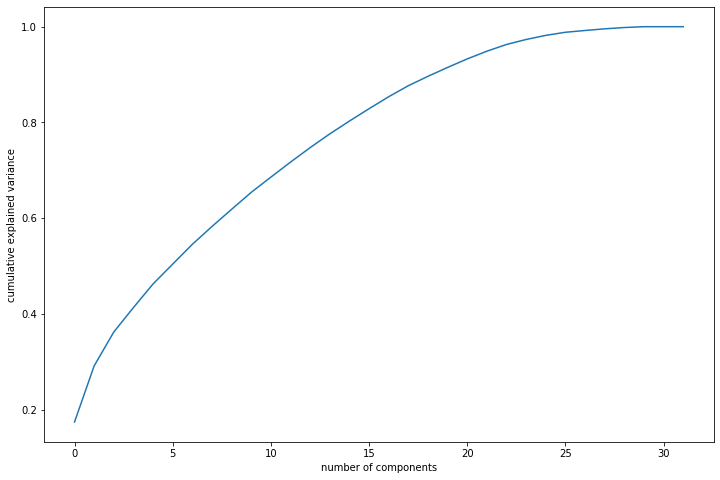

In [243]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [244]:
from sklearn.decomposition import IncrementalPCA
pca = IncrementalPCA(n_components=20)

In [245]:
X_train_pca=pca.fit_transform(X_train)

In [246]:
X_train_pca.shape

(1318, 20)

In [247]:
pca.components_

array([[ 3.68115663e-01,  3.29884599e-01,  3.58354277e-01,
         3.63235959e-01,  3.80128839e-01,  5.94825535e-02,
         1.24422129e-01,  1.68292482e-01,  1.44131817e-01,
        -2.22475477e-01,  1.26815649e-01,  1.17256785e-01,
        -6.55350662e-02, -1.03398832e-02,  3.36254201e-02,
         4.47850025e-02, -2.00150576e-02,  1.63512407e-02,
         1.92092853e-02,  3.96924526e-02,  2.14381404e-02,
        -8.15416620e-03,  2.66584044e-03, -2.28368644e-01,
        -3.28422006e-02, -9.39731481e-03,  4.36975553e-02,
         2.57734608e-01,  1.07527969e-02,  1.68292482e-01,
         1.99359719e-01,  5.33576385e-02],
       [-1.88721616e-01, -1.84830001e-01, -1.96043347e-01,
        -1.86484320e-01, -2.02444084e-01, -5.66787066e-03,
         6.69487561e-02,  3.57846940e-01,  3.65266660e-01,
        -2.33988498e-01,  3.06226085e-01,  8.94196107e-03,
         1.90074319e-02,  1.23731319e-01, -9.95371050e-03,
        -3.47559511e-02, -9.56793386e-03,  1.23246213e-02,
        -5.24

In [248]:
colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head(20)

,PC1,PC2,Feature
0,0.368116,-0.188722,usnews_score_natl
1,0.329885,-0.184830,usnews_score_regl
2,0.358354,-0.196043,amlaw_score_niep
3,0.363236,-0.186484,amlaw_score_rev_rank
4,0.380129,-0.202444,lawfirm_score
5,0.059483,-0.005668,company_score
6,0.124422,0.066949,generic_high_damages_score
7,0.168292,0.357847,non_punitive_damages_score
8,0.144132,0.365267,max_money_score
9,-0.222475,-0.233988,is_low_damage


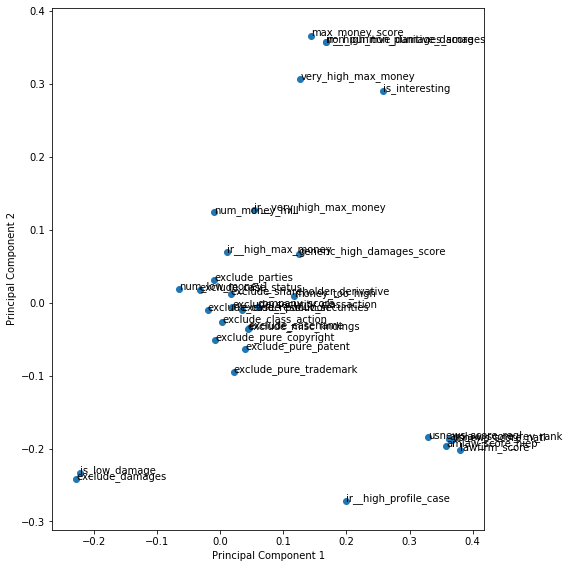

In [249]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

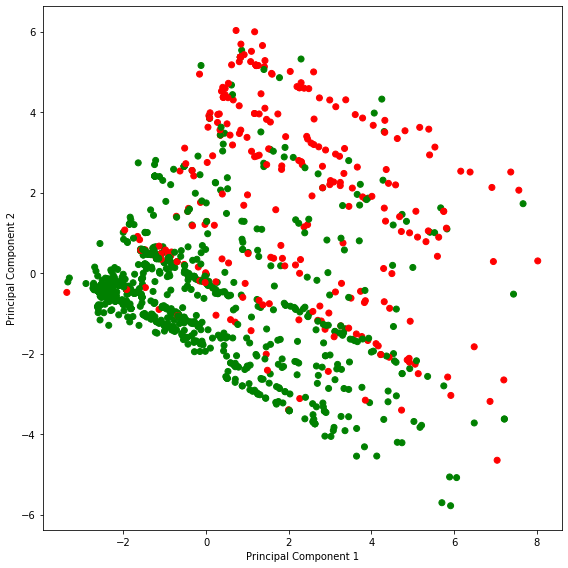

In [250]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c = y_train.map({0:'green',1:'red'}))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

In [251]:
X_train.head()

,usnews_score_natl,usnews_score_regl,amlaw_score_niep,amlaw_score_rev_rank,lawfirm_score,company_score,generic_high_damages_score,non_punitive_damages_score,max_money_score,is_low_damage,...,exclude_class_action,exclude_damages,exclude_case_status,exclude_parties,exclude_misc_findings,is_interesting,ir__high_max_money,ir__high_non_punitive_damages,ir__high_profile_case,ir__very_high_max_money
0,-0.775256,-0.825292,-0.749445,-0.730061,-0.836931,-0.672002,-0.378429,-0.378292,-0.459779,-0.933954,...,-0.181426,-1.035532,-0.087437,-0.038984,-0.103616,-0.566252,-0.160253,-0.378292,-0.389997,-0.204688
1,-0.775256,0.017587,-0.749445,-0.730061,-0.558201,2.175903,-0.378429,-0.378292,-0.459779,1.467902,...,-0.181426,0.965687,-0.087437,-0.038984,-0.103616,-0.566252,-0.160253,-0.378292,-0.389997,-0.204688
2,-0.775256,-0.403853,-0.749445,-0.730061,-0.697566,-0.672002,-0.378429,-0.378292,-0.459779,-0.933954,...,-0.181426,-1.035532,-0.087437,-0.038984,-0.103616,-0.566252,-0.160253,-0.378292,-0.389997,-0.204688
3,-0.416608,-0.403853,-0.010650,0.108110,-0.279470,0.277300,-0.378429,-0.378292,-0.459779,-0.933954,...,-0.181426,-1.035532,-0.087437,-0.038984,-0.103616,-0.566252,-0.160253,-0.378292,-0.389997,-0.204688
4,-0.416608,-0.403853,-0.749445,-0.730061,-0.558201,-0.672002,-0.378429,-0.378292,-0.459779,-0.933954,...,-0.181426,-1.035532,-0.087437,-0.038984,-0.103616,-0.566252,-0.160253,-0.378292,-0.389997,-0.204688


In [252]:
corrmat = np.corrcoef(X_train_pca.transpose())

In [253]:
corrmat.shape

(20, 20)

In [254]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.011284723285003712 , min corr:  -0.015338561132706298


In [255]:
X_test_pca = pca.transform(X_test)
X_test_pca.shape

(566, 20)

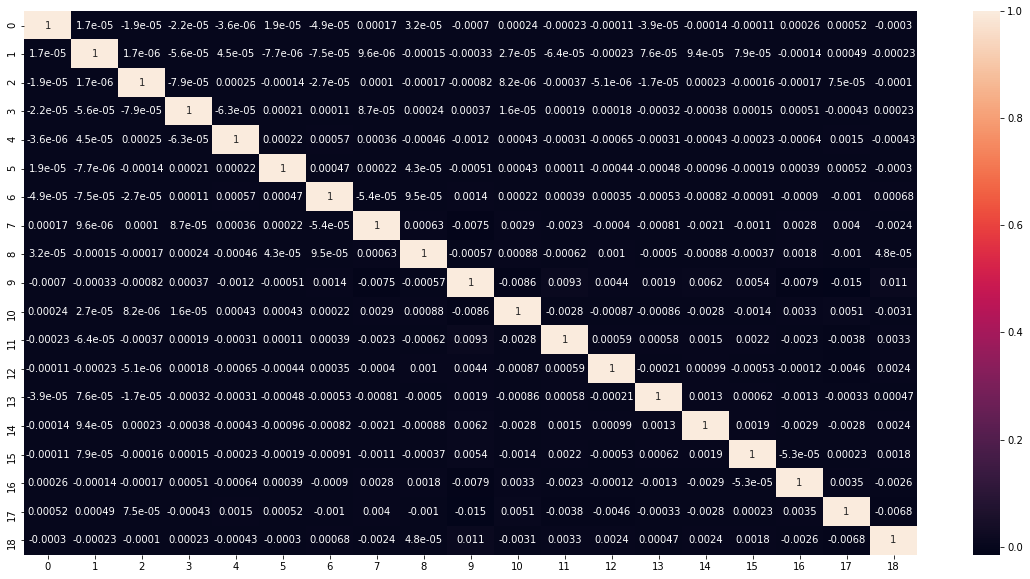

In [256]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat[0:19,0:19],annot = True)

## Logistic Regression Using PCA

In [257]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics

learner_pca = LogisticRegressionCV(class_weight='balanced',cv=20)
model_pca = learner_pca.fit(X_train_pca,y_train)

In [258]:
#Making prediction on the train data
y_train_pred = model_pca.predict_proba(X_train_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_train, y_train_pred))

'0.91'

In [259]:
#Making prediction on the test data
y_pred = model_pca.predict_proba(X_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, y_pred))

'0.93'

In [260]:
y_pred=pd.Series(y_pred)
y_train_pred=pd.Series(y_train_pred)

In [261]:
y_pred_bool= y_pred.apply(lambda x: 1 if x>=0.5 else 0)
y_train_pred_bool= y_train_pred.apply(lambda x: 1 if x>=0.5 else 0)

In [262]:
confusion_matrix(y_train,y_train_pred_bool)

array([[905, 144],
       [ 52, 217]])

In [263]:
confusion_matrix(y_test,y_pred_bool)

array([[388,  63],
       [ 22,  93]])

In [264]:
get_model_metrics(y_test,y_pred_bool)

Accuracy    : 0.85
Sensitivity : 0.81
Specificity : 0.86
Precision   : 0.6
Recall      : 0.81
F1_score    : 0.86


#### Cross Validation k fold Training Set Report

In [265]:
cross_validated_metrics=get_cross_validated_model_metrics(X_train_pca, y_train,cv=10)

In [266]:
cross_validated_metrics.mean()

accuracy       0.845932
precision      0.591917
recall         0.802707
f1_weighted    0.853967
roc_auc        0.912360
dtype: float64

In [267]:
cross_validated_metrics

,accuracy,precision,recall,f1_weighted,roc_auc
0,0.856061,0.605263,0.851852,0.864262,0.924515
1,0.848485,0.600000,0.777778,0.855260,0.907937
2,0.833333,0.560976,0.851852,0.844538,0.917460
3,0.840909,0.583333,0.777778,0.848711,0.904056
4,0.848485,0.606061,0.740741,0.853832,0.911817
5,0.833333,0.567568,0.777778,0.842188,0.914286
6,0.909091,0.727273,0.888889,0.912299,0.950265
7,0.848485,0.585366,0.888889,0.858671,0.929101
8,0.825758,0.555556,0.740741,0.834303,0.902293
9,0.815385,0.527778,0.730769,0.825611,0.861871


#### Cross Validation k fold Test Report

In [268]:
cross_validated_metrics=get_cross_validated_model_metrics(X_test_pca, y_test,cv=10)

In [269]:
cross_validated_metrics.mean()

accuracy       0.855096
precision      0.622967
recall         0.827273
f1_weighted    0.862922
roc_auc        0.925116
dtype: float64

In [270]:
cross_validated_metrics

,accuracy,precision,recall,f1_weighted,roc_auc
0,0.827586,0.562500,0.750000,0.835983,0.860507
1,0.877193,0.647059,0.916667,0.884168,0.925926
2,0.824561,0.555556,0.833333,0.835840,0.923148
3,0.859649,0.700000,0.583333,0.854795,0.924074
4,0.929825,0.785714,0.916667,0.931726,0.962963
5,0.857143,0.588235,0.909091,0.867347,0.937374
6,0.732143,0.400000,0.727273,0.756144,0.856566
7,0.821429,0.526316,0.909091,0.836527,0.939394
8,0.910714,0.714286,0.909091,0.914532,0.967677
9,0.910714,0.750000,0.818182,0.912154,0.953535
